## Computing Vision Business Recommendations

### Business Understanding

Computing Vision is in a competitive industry and is looking to expand its business by creating original video content. The company has decided to create a new movie studio, but they don’t have much background in creating movies. As Deloitte professionals, we are responsible for exploring what types of films are currently doing the best at the box office using different samples of available data. After conducting extensive data analysis, our team will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.

#### Problem

Computing Vision wants to successfully expand its business into the movie industry.

#### Stakeholders

The stakeholders as they relate to this problem are Computing Vision as an organization, any members of the board or employees at the organization, and customers or clients of the organization. These groups are all impacted by the decisions Computing Vision makes.

### Load in Data

#### Data Sources Used for Analysis

IMDB: Database that contains information from the IMDB website, including general movie information. The data was collected within the SQL database, using the movies_basics, movie_ratings, directors, and persons tables and joined with the respective movie IDs

Numbers & TheMovieDB: Datasets that contain information about movie popularity, movie budget, and total grossing information from themoviedb.org and the-numbers.com.

In [171]:
# import necessary packages
import pandas as pd
import numpy as np
import sqlite3
from pandasql import sqldf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# load in data sets - some were not used in final analysis
boxoffice = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_table('zippedData/rt.movie_info.tsv.gz')
reviews = pd.read_table('zippedData/rt.reviews.tsv.gz', encoding='windows-1252')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', index_col=0)
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', index_col=0)

# connect to database
conn = sqlite3.connect('zippedData/im.db')

pysqldf = lambda q: sqldf(q, globals())

### Create Master Dataset

In [172]:
# join "movie_basics" and "movie_ratings" tables
joined = pd.read_sql(
    """SELECT * 
    FROM movie_basics mb 
     JOIN movie_ratings mr 
      ON mb.movie_id=mr.movie_id 
     JOIN directors d 
      ON mb.movie_id = d.movie_id 
     JOIN persons p 
       ON d.person_id = p.person_id;""", conn)

# join "movie_budgets" and "movies" data with "joined" data above
q = """SELECT * FROM joined j JOIN movie_budgets mb ON mb.movie=j.primary_title JOIN movies m ON m.original_title=j.original_title"""
master_df = pysqldf(q).drop_duplicates(subset='primary_title', keep='first')

The finalized data frame used for analysis combines the information from the two sources of data above, as well as profit calculations. We joined movie_basics with movie_ratings on ID, as they are both from the IMDB database. We then joined that table with two other movie datasets to create the master dataframe above.

### Data Cleaning

Through our data cleaning, we dropped columns unneccessary for our analysis, we renamed duplicate column names to reflect their data sources, we converted two columns into lists, and we converted several columns to integers. We then used worldwide and domestic gross along with production budget to calculate worldwide and domestic profit. 

In [173]:
# drop unneccessary columns
new_master_df = master_df.drop(["original_title", "id", "start_year", "movie", "title", "genre_ids", "original_language", "birth_year", "death_year", 'release_date'], axis=1)

# rename "duplicate" columns to reflect data source
new_master_df = new_master_df.rename(columns={"vote_average": "tmdb_vote_average",
                                              "vote_count": "tmdb_vote_count", 
                                              "averagerating": "imdb_average_rating", 
                                              "numvotes": "imdb_vote_count"})

# convert the "genres" and "primary_profession" column into a list
new_master_df["genres"] = new_master_df["genres"].str.split(',')
new_master_df["primary_profession"] = new_master_df["primary_profession"].str.split(',')
new_master_df

# convert "domestic_gross", "production_budget", "worldwide_gross" to integers 
new_master_df['domestic_gross'] = new_master_df['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['production_budget'] = new_master_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
new_master_df['worldwide_gross'] = new_master_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)
final_master_df = new_master_df
final_master_df

# calculate "domestic_profit" and "worldwide_profit" by subtracting "production_budget" from "domestic_gross" and "worldwide_gross"
final_master_df['domestic_profit'] = final_master_df['domestic_gross'] - final_master_df['production_budget']
final_master_df['worldwide_profit'] = final_master_df['worldwide_gross'] - final_master_df['production_budget']
final_master_df.head(3)

,movie_id,primary_title,runtime_minutes,genres,imdb_average_rating,imdb_vote_count,person_id,primary_name,primary_profession,production_budget,domestic_gross,worldwide_gross,popularity,tmdb_vote_average,tmdb_vote_count,domestic_profit,worldwide_profit
0,tt0249516,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,8248,nm0440415,Lawrence Kasanoff,"[producer, writer, director]",45000000,0,73706,4.705,2.1,46,-45000000,-44926294
5,tt0326592,The Overnight,88.0,None,7.5,24,nm1208371,Jed I. Goodman,"[camera_department, writer, producer]",200000,1109808,1165996,6.576,6.0,200,909808,965996
7,tt0337692,On the Road,124.0,"[Adventure, Drama, Romance]",6.1,37886,nm0758574,Walter Salles,"[director, producer, writer]",25000000,720828,9313302,8.919,5.6,518,-24279172,-15686698


### Choosing the Metric: Profit

There is a slightly positive correlation between rating and profit for movies with a minimum of 1000 votes.

In [174]:
# correlation between "popularity" and "worldwide_profit"
popularity_correlation = final_master_df['popularity'].corr(final_master_df['worldwide_profit'])
popularity_correlation

0.597382642103372

There is a slightly positive correlation between popularity and worldwide profit.

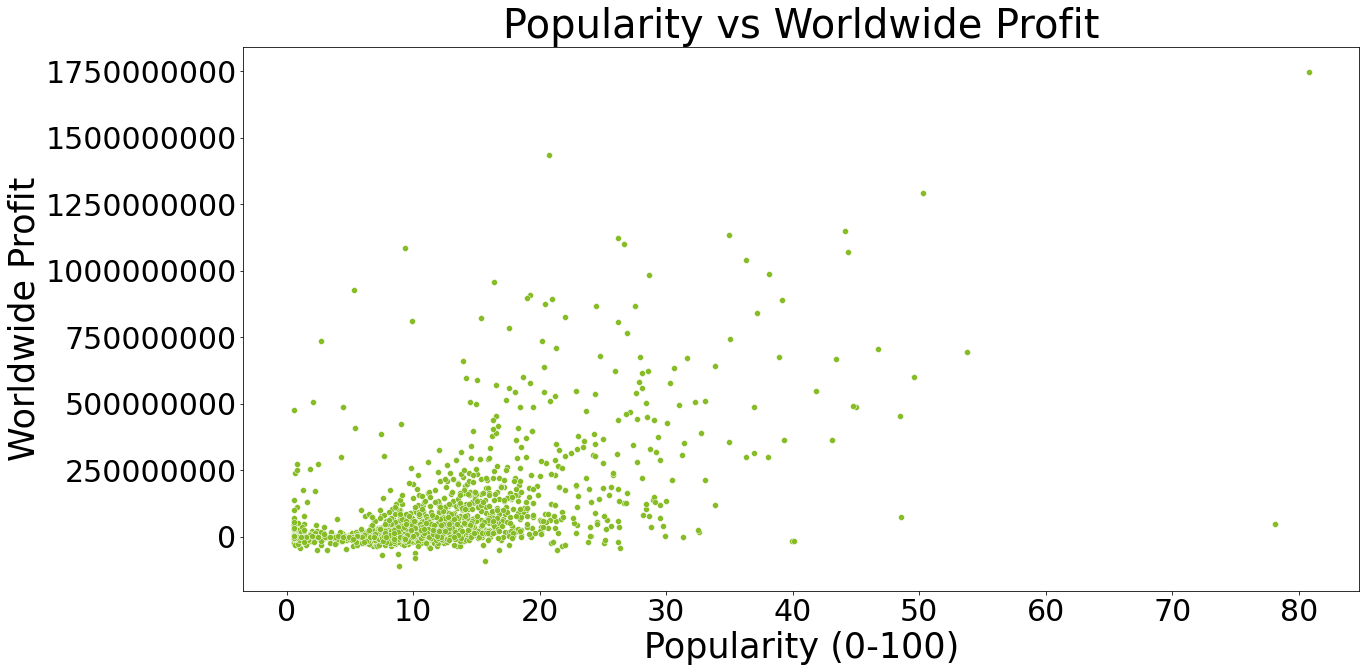

In [175]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['worldwide_profit'], 
                x=final_master_df['popularity'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "Popularity vs Worldwide Profit", fontsize=40)
plt.xlabel("Popularity (0-100)", fontsize=35)
plt.ylabel("Worldwide Profit", fontsize=35)

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [176]:
# correlation between "imdb_average_rating" and "worldwide_profit"
average_rating = final_master_df['imdb_average_rating'].corr(final_master_df['worldwide_profit'])
average_rating

0.25093081799095923

In [ ]:
# scatterplot showing the relationship between "popularity" and "worldwide_profit"
plt.figure(figsize=(20, 10))
sns.scatterplot(y=final_master_df['worldwide_profit'], 
            x=final_master_df['imdb_average_rating'], color="#86BC25")

# set barplot title and axes labels
plt.title(label = "IMDB Average Rating vs Worldwide Profit", fontsize=40)
plt.xlabel("Average Rating (0-10.0)", fontsize=35)
plt.ylabel("Worldwide Profit", fontsize=35)

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

Profit was not initially included in our finalized dataset, so we calculated profit by subtracting production budget from gross worldwide revenue. Although profit isn't a perfect correlation with a movie's popularity and rating, profit is positively correlated with both a movie's popularity and its rating. It may not be a perfect correlation due to higher or lower production budgets for certain movies or the presence of other factors that may impact a movie's profit but not its popularity and rating. However, with the positive correlation with both other metrics, we considered that profit is not only indicative of financial measures important to stakeholders but also of audience preferences and popularity. We thought it was important to capture both parties within a metric representing a movie's success. 

### Recommendation #1: Genre

In [ ]:
# explode table based on genres
final = final_master_df
final = final.dropna()
final.reset_index(drop=True)
final = final.explode('genres')
final.head(3)

We exploded the table and dropped null values in order to perform the genre calculations below.

In [ ]:
# find the mean of different genres of movies
comedy = final[final['genres'] == 'Comedy'].mean()
action = final[final['genres'] == 'Action'].mean()
animation = final[final['genres'] == 'Animation'].mean()
drama = final[final['genres'] == 'Drama'].mean()
horror = final[final['genres'] == 'Horror'].mean()
mystery = final[final['genres'] == 'Mystery'].mean()
scifi = final[final['genres'] == 'Sci-Fi'].mean()
adventure = final[final['genres'] == 'Adventure'].mean()
romance = final[final['genres'] == 'Romance'].mean()
thriller = final[final['genres'] == 'Thriller'].mean()
crime = final[final['genres'] == 'Crime'].mean()
biography = final[final['genres'] == 'Biography'].mean()
fantasy = final[final['genres'] == 'Fantasy'].mean() 
family = final[final['genres'] == 'Family'].mean()


# create dictionary of genres and means
genre_profit = {"Comedy":comedy, "Action": action, "Animation": animation, "Drama": drama, "Horror": horror,
               "Mystery": mystery, "Sci-fi": scifi, "Adventure": adventure, "Romance": romance, "Thriller": thriller, 
                "Crime": crime, "Biography": biography, "Fantasy": fantasy, "Family": family}

# create a dataframe from the dictionary above
mean_df = pd.DataFrame(genre_profit)

# get worldwide profit; sort and prepare for graph below
genres = mean_df.iloc[[10]]
genres = genres.T.sort_values("worldwide_profit", ascending=False)
genres = genres.reset_index()

# graph mean worldwide profit for different genres of movies
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']
plt.figure(figsize=(40, 25))
sns.barplot(x="index", y="worldwide_profit", data=genres, palette = colors)

# set barplot title and axes labels
plt.xlabel('Genres', fontsize = 35)
plt.ylabel('Mean Worldwide Profit', fontsize = 35)
plt.title('Mean Worldwide Profit for Different Genres of Movies', fontsize = 40);

# set x and y tick size
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

We calculated the mean of all columns for the most popular genres. We then isolated the worldwide_profit value. We graphed these values in descending order. 

### Recommendation #2: Directors

In [ ]:
# filter by directors who have produced 5+ movies
final = final.groupby("primary_name").filter(lambda x: len(x) >= 5)

In [ ]:
directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(3)

In [ ]:
# create barplot of the top 8 directors with Deloitte color palette
d = directors_profit.head(8)
plt.figure(figsize=(35, 25))
colors = ['#86BC25', '#43B02A', '#26890D', '#0D8390', 
          '#007CB0', '#046A38', '#86BC25','#43B02A', 
          '#26890D', '#0D8390', '#007CB0', '#046A38', 
          '#43B02A', '#26890D']

ax = sns.barplot(x=d.index, y= d['worldwide_gross'], palette = colors)  

# set barplot title and axes labels
plt.title(label = "Top 8 Movie Directors with the Highest Average Profit", fontsize=40)
plt.xlabel("Directors", fontsize=35)
plt.ylabel("Average Worldwide Profit", fontsize=35)

# set x and y tick size and format tick labels
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(size = 30)
plt.yticks(size = 30);

In [ ]:
# numerical summary of the data above
directors_profit = final.groupby('primary_name').mean()['worldwide_gross'].sort_values(ascending=False).to_frame()
directors_profit.head(8)

In [ ]:
# top 3 directors
directors_profit.head(3)

### Recommendation #3: Runtime

#### Confidence Intervals

To begin our analysis, we decided it would be best to find the confidence interval of the runtime minutes of a movie to have a range of values that most movies average around. With the confidence interval, we want to conduct hypothesis testing to test whether the range of runtime values impacts profitability which will be done after calculating the confidence interval

In [ ]:
# runtime statistics across all genres
runtime = pd.DataFrame(final, columns=['runtime_minutes'])
print(runtime.describe()) 

In [ ]:
# profitability statistics across all genres
profit = pd.DataFrame(final, columns=['worldwide_profit'])
print(profit.describe())

In [ ]:
# histogram to show the distribution of "runtime"
pd.DataFrame(runtime).hist(bins='auto',figsize=(9,9));

As you can see in the histogram above, the distribution of the runtime is unimodal and looks almost normal. Let's calculate a 68% confidence interval just to start off our analysis.

In [ ]:
pd.DataFrame(profit).hist(bins='auto',figsize=(9,9));

While majority of films seem to fall in a specific range in the histogram above, it is positively skewed. We want to test if there is a signficance on the profit distribution.

In [ ]:
# calculating the confidence interval within 1 standard deviation of the mean. A 68% chance that the runtime value would 
# fall in this range
stats.norm.interval(0.68, loc=runtime.mean(), scale=runtime.std())

We chose one standard deviation for runtime, because we didn't want a wide range of values for the runtime of the movie that would have a significant impact on other factors such as popularity or how many people watched it (this is an assumption). This is just a starting point to test significance.

According to our calculation above the runtime within one standard deviation ranges from approximately 87.3 minutes to 122.7 minutes.

#### Hypothesis Testing

Now that we have our confidence interval, we want to test if having a value within this range of runtime minutes (inclusive) positively impacts profitability. In simpler terms, does this range of runtime minutes ensure that the movie would be more profitable than movies with runtimes outside of this range.

Null Hypothesis: A runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability.

Alternate Hypothesis: A runtime between 87.3 and 122.7 minutes will positively impact profitability

Since we are testing significance between two values, we are conducting a two-tailed test for our hypothesis testing

In [ ]:
sample_df1 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
sample_df1.head(3)

The datframe above is simply a filtered version of our original dataframe where it only includes rows that have a runtime value within the range listed above.

In [ ]:
#mean lowered in this range
sample_df1['worldwide_profit'].describe() 

We can see above that this range has a worldwide profit of 63 million dollars on average with a maximum value of 1.12 billion dollars in profit. Let's test to see whether the runtime values impact the profitability

#### Two-Tailed Hypothesis Testing

In [ ]:
# sample of all runtimes within the range of 87.29 to 122.67 mins
group_runtime = sample_df1['runtime_minutes']

# the respective worldwide 
group_profit = sample_df1['worldwide_profit']

t_statistic, p_value = stats.ttest_ind(group_runtime,group_profit)

alpha = 0.05

In [ ]:
# results interpretation
if p_value < alpha:
    print("Reject null hypothesis, a runtime between 87.3 and 122.7 minutes will positively impact profitability")
else:
    print("Fail to reject null hypothesis, a runtime between 87.3 and 122.7 minutes will negatively impact or not impact profitability")

#### Testing to Find the Most Profitable Runtime Ranges

We already found 68% of the data spread range around the mean runtime. Let's expand the spread to 95% of the population and divide it into intervals based on standard deviations.

In [ ]:
stats.norm.interval(0.95, loc=runtime.mean(), scale=runtime.std())

In [ ]:
sample_df2 = final[final['runtime_minutes'].between(0, 70.1199682, inclusive=True)]
sample_df3 = final[final['runtime_minutes'].between(70.1199682, 87.29524865, inclusive=True)]
sample_df4 = final[final['runtime_minutes'].between(87.29524865, 122.67584961, inclusive=True)]
sample_df5 = final[final['runtime_minutes'].between(122.67584961, 139.85113007, inclusive=True)]
sample_df6 = final[final['runtime_minutes'].between(139.85113007, 180, inclusive=True)]

In [ ]:
#no movies between these runtimes in our cleaned dataframe
sample_df2['worldwide_profit'].describe()

In [ ]:
sample_df3['worldwide_profit'].describe() 

In [ ]:
sample_df4['worldwide_profit'].describe() 

In [ ]:
sample_df5['worldwide_profit'].describe()

In [ ]:
sample_df6['worldwide_profit'].describe()

The sample_df6 range had the highest profitability on average and included the data point that had the highest worldwide profit in the dataset. While the count of data poins varied in each of these samples, we also observed the quartiles and maximum values in the respective intervals to back our recommendation. sample_df6 has a range of approximately 140 to 180 minutes of runtime with an average profitability of 295 million dollars, including the maximum value of 1.75 billion.

Another observation is the range of profit values fluctuated as the runtime increased. While there is an overall positive correlation, the profit did not consistently increase as the runtime minutes increased.

Optimal runtime range is approximately 140 to 180 minutes for the most profitable films worldwide and across all genres

#### Two-Tailed Hypothesis Testing: Test Significance of range 140 to 180 minutes of runtime on worldwide profit

Null Hypothesis: A runtime between 140 and 180 minutes will negatively impact or not impact profitability

Alternate Hypothesis: A runtime between 140 and 180 minutes will positively impact profitability

In [ ]:
group_runtime1 = sample_df6['runtime_minutes']
group_profit1 = sample_df6['worldwide_profit']

t_statistic1, p_value1 = stats.ttest_ind(group_runtime1, group_profit1)

alpha = 0.05

In [ ]:
# results interpretation
if p_value1 < alpha:
    print("Reject null hypothesis, a runtime between 140 and 180 minutes will positively impact profitability")
else:
    print("Fail to reject null hypothesis, a runtime between 140 and 180 minutes will negatively impact or not impact profitability")

#### Summary of Statistical Analysis

We wanted Computing Vision to have a metric for a runtime that would be most profitable for them. Before we tested this, we wanted to test the significance of runtime on profit, to see if it truly has an impact. With 95% confidence, we found that there is a significance and we were able to reject the null hypothesis.

We then moved on to find other ranges that might have been more profitable, and we found that the most profitable movies on average have a runtime that ranges from 140 to 180 minutes. To ensure that this range still had an effect on the profit we ran the hypothesis test again to confirm its impact on worldwide profit.

### Conclusion

Overall, our recommendations provide Computing Vision with actionable insights to decide what types of films they should specialize in for their new movie studio. These include Animation, Adventure, and Science Fiction movies with an emphasis on movies directed by one of the top directors within your desired genre. Further, we recommend the movie be within the optimal runtime of 140 to 180 minutes to generate the most profit. With these 3 recommendations, we believe that Computing Vision will be successful in starting a new movie studio.